In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import initializers
import keras.backend as K
import numpy as np
from tensorflow.keras.layers import *
from keras.regularizers import l2#正则化

Using TensorFlow backend.


In [2]:
#准备训练数据
import pandas as pd
import numpy as np
normal_all = pd.read_csv(r'F:\张老师课题学习内容\code\数据集\试验数据(包括压力脉动和振动)\2013.9.12-未发生缠绕前\2013-9-12压力脉动\1450-txt\normal_420_通道7.txt')
chanrao_all = pd.read_csv(r'F:\张老师课题学习内容\code\数据集\试验数据(包括压力脉动和振动)\2013.9.17-发生缠绕后\压力脉动\1450-txt\chanrao_420_通道7.txt')  

normal=normal_all[["通道7"]]
chanrao=chanrao_all[["通道7"]]
chanrao=chanrao[0:120000]

In [3]:
#水泵的两种故障类型信号normal正常，chanrao故障
normal=normal.values.reshape(-1, 800)#(120000,1)-(150, 800)150条长度为800
chanrao=chanrao.values.reshape(-1, 800)
print(normal_all.shape,chanrao_all.shape)
print(normal.shape,chanrao.shape)

(120000, 2) (120000, 2)
(150, 800) (150, 800)


In [4]:
import numpy as np
def yuchuli(data,label):#(7:1)(616:88)
    #打乱数据顺序
    np.random.shuffle(data)
    train = data[0:120,:]
    test = data[120:150,:]
    label_train = np.array([label for i in range(0,120)])
    label_test =np.array([label for i in range(0,30)])
    return train,test ,label_train ,label_test

def stackkk(a,b,c,d,e,f,g,h):
    aa = np.vstack((a, e))
    bb = np.vstack((b, f))
    cc = np.hstack((c, g))
    dd = np.hstack((d, h))
    return aa,bb,cc,dd
x_tra0,x_tes0,y_tra0,y_tes0 = yuchuli(normal,0)
x_tra1,x_tes1,y_tra1,y_tes1 = yuchuli(chanrao,1)
tr1,te1,yr1,ye1=stackkk(x_tra0,x_tes0,y_tra0,y_tes0 ,x_tra1,x_tes1,y_tra1,y_tes1)

x_train=tr1
x_test=te1
y_train = yr1
y_test = ye1

#打乱数据
state = np.random.get_state()
np.random.shuffle(x_train)
np.random.set_state(state)
np.random.shuffle(y_train)

state = np.random.get_state()
np.random.shuffle(x_test)
np.random.set_state(state)
np.random.shuffle(y_test)


#对训练集和测试集标准化
def ZscoreNormalization(x):
    """Z-score normaliaztion"""
    x = (x - np.mean(x)) / np.std(x)
    return x
x_train=ZscoreNormalization(x_train)
x_test=ZscoreNormalization(x_test)

#转化为二维矩阵
x_train = x_train.reshape(-1,800,1,1)
x_test = x_test.reshape(-1,800,1,1)
print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)

def to_one_hot(labels,dimension=2):
    results = np.zeros((len(labels),dimension))
    for i,label in enumerate(labels):
        results[i,label] = 1
    return results
one_hot_train_labels = to_one_hot(y_train)
one_hot_test_labels = to_one_hot(y_test)
print(x_train.shape,x_test.shape)

(240, 800, 1, 1) (60, 800, 1, 1)
(240,) (60,)
(240, 800, 1, 1) (60, 800, 1, 1)


In [5]:
#定义挤压函数
def squash(vectors, axis=-1):
    """
    对向量的非线性激活函数
    ## vectors: some vectors to be squashed, N-dim tensor
    ## axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True)
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors

class Length(layers.Layer):
    """
    计算向量的长度。它用于计算与margin_loss中的y_true具有相同形状的张量
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
         return input_shape[:-1]
        
    def get_config(self):
        config = super(Length, self).get_config()
        return config
#定义预胶囊层
def PrimaryCap(inputs, dim_capsule, n_channels, kernel_size, strides, padding):
    """
    进行普通二维卷积 `n_channels` 次, 然后将所有的胶囊重叠起来
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_capsule: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_capsule]
    """
    output = layers.Conv2D(filters=dim_capsule*n_channels, kernel_size=kernel_size, strides=strides,
                           padding=padding,name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_capsule], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

class DenseCapsule(layers.Layer):
    """
    胶囊层. 输入输出都为向量. 
    ## num_capsule: 本层包含的胶囊数量
    ## dim_capsule: 输出的每一个胶囊向量的维度
    ## routings: routing 算法的迭代次数
    """
    def __init__(self, num_capsule, dim_capsule, routings=3, kernel_initializer='glorot_uniform',**kwargs):
        super(DenseCapsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = kernel_initializer

    def build(self, input_shape):
        assert len(input_shape) >= 3, '输入的 Tensor 的形状[None, input_num_capsule, input_dim_capsule]'#(None,1152,8)
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]

        #转换矩阵
        self.W = self.add_weight(shape=[self.num_capsule, self.input_num_capsule,
                                        self.dim_capsule, self.input_dim_capsule],
                                initializer=self.kernel_initializer,name='W')
        self.built = True

    def call(self, inputs, training=None):
        # inputs.shape=[None, input_num_capsuie, input_dim_capsule]
        # inputs_expand.shape=[None, 1, input_num_capsule, input_dim_capsule]
        inputs_expand = K.expand_dims(inputs, 1)
        # 运算优化:将inputs_expand重复num_capsule 次，用于快速和W相乘
        # inputs_tiled.shape=[None, num_capsule, input_num_capsule, input_dim_capsule]
        inputs_tiled = K.tile(inputs_expand, [1, self.num_capsule, 1, 1])

        # 将inputs_tiled的batch中的每一条数据，计算inputs+W
        # x.shape = [num_capsule, input_num_capsule, input_dim_capsule]
        # W.shape = [num_capsule, input_num_capsule, dim_capsule, input_dim_capsule]
        # 将x和W的前两个维度看作'batch'维度，向量和矩阵相乘:
        # [input_dim_capsule] x [dim_capsule, input_dim_capsule]^T -> [dim_capsule].
        # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsutel
        inputs_hat = K.map_fn(lambda x: K.batch_dot(x, self.W, [2, 3]),elems=inputs_tiled)

        # Begin: Routing算法
        # 将系数b初始化为0.
        # b.shape = [None, self.num_capsule, self, input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.num_capsule, self.input_num_capsule])
        
        assert self.routings > 0, 'The routings should be > 0.'
        for i in range(self.routings):
            # c.shape=[None, num_capsule, input_num_capsule]
            C = tf.nn.softmax(b ,axis=1)
            # c.shape = [None, num_capsule, input_num_capsule]
            # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
            # 将c与inputs_hat的前两个维度看作'batch'维度，向量和矩阵相乘:
            # [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule],
            # outputs.shape= [None, num_capsule, dim_capsule]
            outputs = squash(K. batch_dot(C, inputs_hat, [2, 2])) # [None, 10, 16]
        
            if i < self.routings - 1:
                # outputs.shape = [None, num_capsule, dim_capsule]
                # inputs_hat.shape = [None, num_capsule, input_num_capsule, dim_capsule]
                # 将outputs和inρuts_hat的前两个维度看作‘batch’ 维度，向量和矩阵相乘:
                # [dim_capsule] x [imput_num_capsule, dim_capsule]^T -> [input_num_capsule]
                # b.shape = [batch_size. num_capsule, input_nom_capsule]
#                 b += K.batch_dot(outputs, inputs_hat, [2, 3]) to this b += tf.matmul(self.W, x)
                b += K.batch_dot(outputs, inputs_hat, [2, 3])

        # End: Routing 算法
        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_capsule])

    def get_config(self):
        config = {
            'num_capsule': self.num_capsule,
            'dim_capsule': self.dim_capsule,
            'routings': self.routings
            }
        base_config = super(DenseCapsule, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [6]:
from tensorflow import keras
from keras.regularizers import l2#正则化
x = layers.Input(shape=[800,1, 1])
#普通卷积层
conv1 = layers.Conv2D(filters=16, kernel_size=(2, 1),activation='relu',padding='valid',name='conv1')(x)
#池化层
POOL1 = MaxPooling2D((2,1))(conv1)
#普通卷积层
conv2 = layers.Conv2D(filters=32, kernel_size=(2, 1),activation='relu',padding='valid',name='conv2')(POOL1)
#池化层
# POOL2 = MaxPooling2D((2,1))(conv2)
#Dropout层
Dropout=layers.Dropout(0.1)(conv2)

# Layer 3: 使用“squash”激活的Conv2D层， 然后重塑 [None, num_capsule, dim_vector]
primarycaps = PrimaryCap(Dropout, dim_capsule=8, n_channels=12, kernel_size=(4, 1), strides=2, padding='valid')
# Layer 4: 数字胶囊层，动态路由算法在这里工作。
digitcaps = DenseCapsule(num_capsule=2, dim_capsule=16, routings=3, name='digit_caps')(primarycaps)
# Layer 5:这是一个辅助层，用它的长度代替每个胶囊。只是为了符合标签的形状。
out_caps = Length(name='out_caps')(digitcaps)

model = keras.Model(x, out_caps)    
model.summary() 

Instructions for updating:
Use fn_output_signature instead
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 800, 1, 1)]       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 799, 1, 16)        48        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 399, 1, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 398, 1, 32)        1056      
_________________________________________________________________
dropout (Dropout)            (None, 398, 1, 32)        0         
_________________________________________________________________
primarycap_conv2d (Conv2D)   (None, 198, 1, 96)        12384     
_________________________________________________________________
pr

In [7]:
#定义优化
model.compile(metrics=['accuracy'],
              optimizer='adam',
              loss=lambda y_true,y_pred: y_true*K.relu(0.9-y_pred)**2 + 0.25*(1-y_true)*K.relu(y_pred-0.1)**2   
             )
import time
time_begin = time.time()
history = model.fit(x_train,one_hot_train_labels,
                    validation_split=0.1,
                    epochs=50,batch_size=10,
                    shuffle=True)
time_end = time.time()
time = time_end - time_begin
print('time:', time)


Epoch 1/50
22/22 [==============================] - 4s 89ms/step - loss: 0.1582 - accuracy: 0.4786 - val_loss: 0.0630 - val_accuracy: 0.5833
Epoch 2/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0689 - accuracy: 0.4919 - val_loss: 0.0528 - val_accuracy: 0.6250
Epoch 3/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0516 - accuracy: 0.6455 - val_loss: 0.0656 - val_accuracy: 0.6250
Epoch 4/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0332 - accuracy: 0.7990 - val_loss: 0.0436 - val_accuracy: 0.6250
Epoch 5/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0283 - accuracy: 0.8899 - val_loss: 0.0556 - val_accuracy: 0.7083
Epoch 6/50
22/22 [==============================] - 1s 42ms/step - loss: 0.0310 - accuracy: 0.8796 - val_loss: 0.0553 - val_accuracy: 0.7917
Epoch 7/50
22/22 [==============================] - 1s 43ms/step - loss: 0.0236 - accuracy: 0.9320 - val_loss: 0.0550 - val_accuracy: 0.7917
Epoch 8/50
22

In [8]:
score = model.evaluate(x_test,one_hot_test_labels, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02543802745640278
Test accuracy: 0.9333333373069763


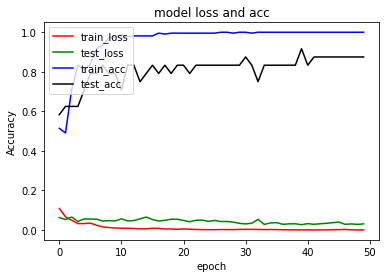

In [9]:
#绘制acc-loss曲线
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['val_loss'],color='g')
plt.plot(history.history['accuracy'],color='b')
plt.plot(history.history['val_accuracy'],color='k')
plt.title('model loss and acc')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'test_loss','train_acc', 'test_acc'], loc='upper left')
# plt.legend(['train_loss','train_acc'], loc='upper left')
#plt.savefig('1.png')
plt.show()

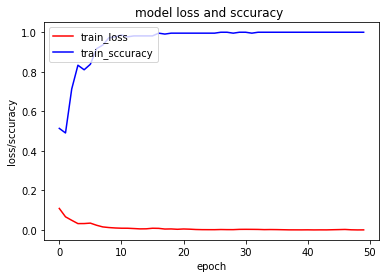

In [10]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'],color='r')
plt.plot(history.history['accuracy'],color='b')
plt.title('model loss and sccuracy ')
plt.ylabel('loss/sccuracy')
plt.xlabel('epoch')
plt.legend(['train_loss', 'train_sccuracy'], loc='upper left')
plt.show()